In [1]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv("/content/ecommerce_returns_synthetic_data.csv")

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

df['return_status'] = df['return_status'].astype(str).str.strip().str.lower()

def classify_return_status(val):
    if pd.isna(val):
        return np.nan
    s = re.sub(r'[_\-\s]+', ' ', val.lower()).strip()
    if s in ['not returned', 'not_returned', 'not-returned', 'no', 'n']:
        return 0
    elif s in ['returned', 'yes', 'y']:
        return 1
    else:
        return np.nan

df['return_flag'] = df['return_status'].apply(classify_return_status)

date_cols = [c for c in df.columns if "date" in c]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=True)

if 'days_to_return' in df.columns:
    df['days_to_return'] = pd.to_numeric(df['days_to_return'], errors='coerce')

cols_to_clear = [c for c in ['return_date', 'return_reason', 'days_to_return'] if c in df.columns]
df.loc[df['return_flag'] == 0, cols_to_clear] = np.nan

if 'order_date' in df.columns and 'return_date' in df.columns:
    valid = df['return_flag'] == 1
    df.loc[valid, 'days_to_return'] = (
        (df.loc[valid, 'return_date'] - df.loc[valid, 'order_date']).dt.days
    )
    df.loc[df['days_to_return'] < 0, 'days_to_return'] = np.nan

categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numeric_cols:
    if col != 'return_flag':
        df[col] = df[col].fillna(df[col].median())

if 'product_category' in df.columns:
    cat_rate = df.groupby('product_category')['return_flag'].mean().rename('category_return_rate')
    df = df.merge(cat_rate, on='product_category', how='left')

if 'supplier' in df.columns:
    sup_rate = df.groupby('supplier')['return_flag'].mean().rename('supplier_return_rate')
    df = df.merge(sup_rate, on='supplier', how='left')

if 'order_date' in df.columns:
    df['order_dayofweek'] = df['order_date'].dt.day_name()

print("Cleaning & Preprocessing Complete!")
print(f"Total Rows: {len(df)}")
print(df['return_flag'].value_counts(dropna=False))
print("\nCheck: Non-empty return info for NOT RETURNED products (should be 0):")
for c in cols_to_clear:
    print(f"{c}: {df.loc[df['return_flag']==0, c].notna().sum()}")

df.to_csv("cleaned_ecommerce_returns.csv", index=False)
print("\nSaved cleaned dataset as 'cleaned_ecommerce_returns.csv'")


Cleaning & Preprocessing Complete!
Total Rows: 10000
return_flag
1    5052
0    4948
Name: count, dtype: int64

Check: Non-empty return info for NOT RETURNED products (should be 0):
return_date: 0
return_reason: 4948
days_to_return: 4948

Saved cleaned dataset as 'cleaned_ecommerce_returns.csv'



Return Rate by Product Category:
product_category
Clothing       0.524500
Electronics    0.509320
Books          0.506614
Toys           0.495370
Home           0.490148
Name: return_flag, dtype: float64


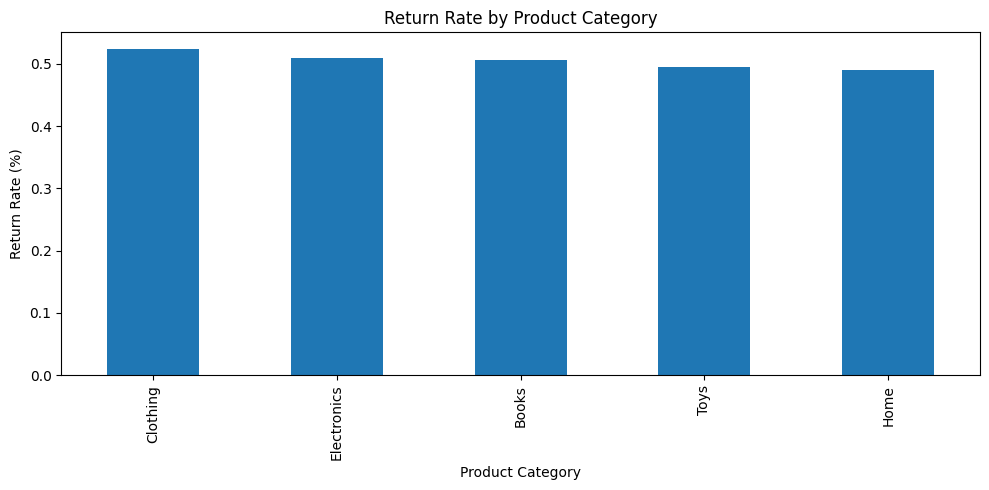


Return rate analysis complete.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("cleaned_ecommerce_returns.csv")

df['return_flag'] = pd.to_numeric(df['return_flag'], errors='coerce')

if 'product_category' in df.columns:
    category_returns = df.groupby('product_category')['return_flag'].mean().sort_values(ascending=False)
    print("\nReturn Rate by Product Category:")
    print(category_returns)

    plt.figure(figsize=(10, 5))
    category_returns.plot(kind='bar')
    plt.title("Return Rate by Product Category")
    plt.ylabel("Return Rate (%)")
    plt.xlabel("Product Category")
    plt.tight_layout()
    plt.show()

if 'supplier' in df.columns:
    supplier_returns = df.groupby('supplier')['return_flag'].mean().sort_values(ascending=False)
    print("\nReturn Rate by Supplier:")
    print(supplier_returns.head(10))  # top 10
    plt.figure(figsize=(10, 5))
    supplier_returns.head(10).plot(kind='bar', color='orange')
    plt.title("Top 10 Suppliers by Return Rate")
    plt.ylabel("Return Rate (%)")
    plt.xlabel("Supplier")
    plt.tight_layout()
    plt.show()

for col in ['region', 'country', 'geography']:
    if col in df.columns:
        geo_returns = df.groupby(col)['return_flag'].mean().sort_values(ascending=False)
        print(f"\nReturn Rate by {col.capitalize()}:")
        print(geo_returns)
        plt.figure(figsize=(10, 5))
        geo_returns.plot(kind='bar', color='green')
        plt.title(f"Return Rate by {col.capitalize()}")
        plt.ylabel("Return Rate (%)")
        plt.xlabel(col.capitalize())
        plt.tight_layout()
        plt.show()

if 'marketing_channel' in df.columns:
    channel_returns = df.groupby('marketing_channel')['return_flag'].mean().sort_values(ascending=False)
    print("\nReturn Rate by Marketing Channel:")
    print(channel_returns)
    plt.figure(figsize=(10, 5))
    channel_returns.plot(kind='bar', color='purple')
    plt.title("Return Rate by Marketing Channel")
    plt.ylabel("Return Rate (%)")
    plt.xlabel("Marketing Channel")
    plt.tight_layout()
    plt.show()

print("\nReturn rate analysis complete.")


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

df = pd.read_csv("cleaned_ecommerce_returns.csv")

target = 'return_flag'
df[target] = pd.to_numeric(df[target], errors='coerce')

potential_features = [
    'product_category', 'supplier', 'price', 'quantity',
    'days_to_return', 'category_return_rate', 'supplier_return_rate',
    'order_dayofweek', 'marketing_channel', 'region'
]

features = [col for col in potential_features if col in df.columns]

model_df = df.dropna(subset=[target])

X = model_df[features]
y = model_df[target]

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Model Evaluation:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

df['return_risk_score'] = model.predict_proba(df[features])[:, 1]

high_risk = df[df['return_risk_score'] > 0.6]
high_risk.to_csv("high_risk_products.csv", index=False)

print("\nHigh-risk products exported as 'high_risk_products.csv'")



Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

           0       0.49      0.46      0.47       990
           1       0.50      0.53      0.51      1010

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000

ROC-AUC Score: 0.5015626562656266

High-risk products exported as 'high_risk_products.csv'
